In [4]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit



In [5]:
# Lectura de datos
titanic_data = pd.read_csv('train.csv')



In [6]:
import seaborn as sns 

C:\Users\limco\AppData\Local\Temp\ipykernel_28004\3970541667.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(titanic_data.corr(), cmap="Blues_r")


NameError: name 'plt' is not defined

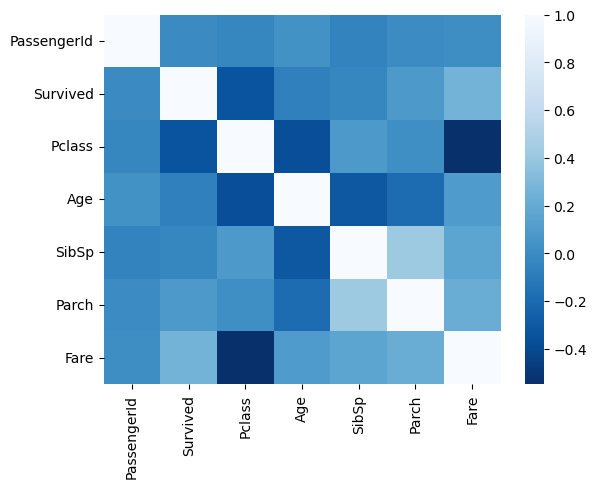

In [7]:
sns.heatmap(titanic_data.corr(), cmap="Blues_r")
plt.show()

In [8]:
# División estratificada
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]



In [31]:

# Transformador SimpleImputer para imputar valores faltantes en la columna 'Age' utilizando la estrategia de la media
class SimpleImpute(BaseEstimator, TransformerMixin):
    
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)
    
    def fit(self, X, y=None):
        self.imputer.fit(X[['Age']])
        return self
    
    def transform(self, X):
        X['Age'] = self.imputer.transform(X[['Age']])
        return X


In [32]:

# Transformador FeatureEncoder para realizar codificación one-hot en las columnas 'Embarked' y 'Sex'
class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.encoder = OneHotEncoder()
    
    def fit(self, X, y=None):
        self.encoder.fit(X[['Embarked', 'Sex']])
        return self
    
    def transform(self, X):
        embarked_sex_encoded = self.encoder.transform(X[['Embarked', 'Sex']]).toarray()
        embarked_sex_columns = ["C", "S", "Q", "female", "male"]
        for i, col in enumerate(embarked_sex_columns):
            X[col] = embarked_sex_encoded[:, i]
        return X


In [33]:


# Transformador FeatureDropper para eliminar columnas no deseadas
class FeatureDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.columns_to_drop is None:
            self.columns_to_drop = ["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"]
        return X.drop(self.columns_to_drop, axis=1, errors="ignore")



In [34]:

# Pipeline actualizado con SimpleImputer y los transformadores definidos
pipeline = Pipeline([
    ("simpleimputer", SimpleImpute()),
    ("featureencoder", FeatureEncoder()),
    ("featuredropper", FeatureDropper())
])

# Aplicar el pipeline al conjunto de entrenamiento
strat_train_set = pipeline.fit_transform(strat_train_set)


In [35]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,female,male
867,868,0,1,31.0,0,0,50.4958,0.0,0.0,1.0,0.0,0.0
619,620,0,2,26.0,0,0,10.5000,0.0,0.0,1.0,0.0,0.0
50,51,0,3,7.0,4,1,39.6875,0.0,0.0,1.0,0.0,0.0
286,287,1,3,30.0,0,0,9.5000,0.0,0.0,1.0,0.0,0.0
834,835,0,3,18.0,0,0,8.3000,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
482,483,0,3,50.0,0,0,8.0500,0.0,0.0,1.0,0.0,0.0
518,519,1,2,36.0,1,0,26.0000,0.0,0.0,1.0,0.0,1.0
54,55,0,1,65.0,0,1,61.9792,1.0,0.0,0.0,0.0,0.0
603,604,0,3,44.0,0,0,8.0500,0.0,0.0,1.0,0.0,0.0


In [36]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 867 to 802
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  female       712 non-null    float64
 11  male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [37]:
# Seleccionar las columnas 'female' y 'male'
gender_counts = strat_train_set[['female', 'male']].value_counts()

# Mostrar el conteo de valores para 'female' y 'male'
print(gender_counts)

female  male
0.0     0.0     462
        1.0     248
1.0     1.0       2
dtype: int64


In [38]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis=1)
Y = strat_train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
Y_data = Y.to_numpy()

In [39]:
X_data

array([[ 1.6422641 , -1.56828591,  0.09549538, ...,  0.61197825,
        -0.05307449, -0.73561236],
       [ 0.67661178, -0.37019624, -0.29160547, ...,  0.61197825,
        -0.05307449, -0.73561236],
       [-1.53893728,  0.82789342, -1.7625887 , ...,  0.61197825,
        -0.05307449, -0.73561236],
       ...,
       [-1.52336225, -1.56828591,  2.72778116, ..., -1.63404501,
        -0.05307449, -0.73561236],
       [ 0.61431163,  0.82789342,  1.10195759, ...,  0.61197825,
        -0.05307449, -0.73561236],
       [ 1.38916974, -1.56828591, -1.45290802, ...,  0.61197825,
        -0.05307449, -0.73561236]])

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]}
]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, Y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [41]:
final_clf = grid_search.best_estimator_

In [42]:
final_clf

RandomForestClassifier(min_samples_split=3, n_estimators=200)

In [43]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [80]:
X_test = strat_test_set.drop(['Survived'] , axis = 1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
x_data_test = scaler.fit_transform(X)
Y_data_test = Y.to_numpy()



In [81]:
final_clf.score(x_data_test,Y_data_test)

0.9943820224719101

In [82]:
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,C,S,Q,female,male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,0.0,0.0,1.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,1.0,0.0,0.0,0.0,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,0.0,1.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,0.0,0.0,1.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,0.0,0.0,1.0,0.0,0.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,0.0,0.0,1.0,0.0,1.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S,0.0,0.0,1.0,0.0,1.0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,1.0,0.0,0.0,0.0,0.0


In [83]:
final_data = pipeline.fit_transform(titanic_data)

In [84]:
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,female,male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,0.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,0.0,1.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,0.0,1.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,0.0,1.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,0.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,0.0,1.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,0.0,1.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,0.0


In [85]:
X_final = final_data.drop(['Survived'] , axis = 1)
Y_final = final_data['Survived']

scaler = StandardScaler()
x_data_final = scaler.fit_transform(X_final)
Y_data_final = Y_final.to_numpy()


In [49]:
prod_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]}
]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(x_data_final, Y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [50]:
prod_final_clf = grid_search.best_estimator_

In [51]:
prod_final_clf

RandomForestClassifier(max_depth=5)

In [53]:
titanic_test_data =  pd.read_csv('test.csv')

In [63]:
final_test_data =  pipeline.fit_transform(titanic_test_data)

In [64]:
final_test_data

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,S,Q,female,male
0,892,3,34.50000,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.00000,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.00000,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.00000,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.00000,1,1,12.2875,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
414,1306,1,39.00000,0,0,108.9000,1.0,0.0,0.0,1.0,0.0
415,1307,3,38.50000,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
416,1308,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [61]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   female       418 non-null    float64
 10  male         418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.1 KB


In [71]:
X_final_test = final_test_data
X_final_testt = X_final_test.fillna(method= "ffill")

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)


In [72]:
prediction = prod_final_clf.predict(X_data_final_test)

In [73]:
prediction

array([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,

In [78]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived']= prediction
final_df.to_csv(r"C:\Users\limco\Titanic Survival Prediction in Python\prediction.csv" , index = False)


In [79]:
final_df

,PassengerId,Survived
0,892,1
1,893,0
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
